# Wat zegt wanneer een foto is genomen over wie er op staat?

In [170]:
%matplotlib inline
import matplotlib.pyplot as plt

In [171]:
tables = [
    'agenda_participants',
    'agenda',
    'committee',
    'mediafiles_mediatags.train',
    'mediafiles_mediatags.dev',
    'mediafiles_mediatags_new',
    'mediacollections',
    'mediatags',
    'person_group',
    'person',
]

In [172]:
%%time
# https://dataset.readthedocs.io/en/latest/quickstart.html
import dataset, csv, datetime

mysql_datetime_formats = [
    '%Y-%m-%d %H:%M:%S.%f',
    '%Y-%m-%d %H:%M:%S',
    '%Y-%m-%d',
    '%H:%M:%S'
]
def try_type(v):
    if v == '\\N' or (not v):
        return None
    for form in mysql_datetime_formats:
        try:
            return datetime.datetime.strptime(v, form)
        except ValueError:
            pass
    try:
        return int(v)
    except ValueError:
        return v.decode('utf8')

# This takes a few seconds
db = dataset.connect('sqlite:///:memory:')
for table_name in tables:
    table = db[table_name]
    with open('%s.tsv' % table_name) as table_file:
        for row in csv.DictReader(table_file, delimiter='\t'):
            row = {k:try_type(v) for k,v in row.items() if try_type(v)}
            try:
                table.insert(row)
            except Exception as e:
                print row
                print e

{'date': datetime.datetime(2009, 1, 23, 0, 0), 'id': 726, 'name': u'Elfbierenborrel'}
(sqlite3.IntegrityError) UNIQUE constraint failed: mediacollections.id [SQL: u'INSERT INTO mediacollections (id, date, name) VALUES (?, ?, ?)'] [parameters: (726, '2009-01-23 00:00:00.000000', u'Elfbierenborrel')]
CPU times: user 2min 5s, sys: 995 ms, total: 2min 6s
Wall time: 2min 13s


In [173]:
q = "SELECT count(*) FROM `mediafiles_mediatags_new` tagging"
print(dict(next(db.query(q))))

{u'count(*)': 95042}


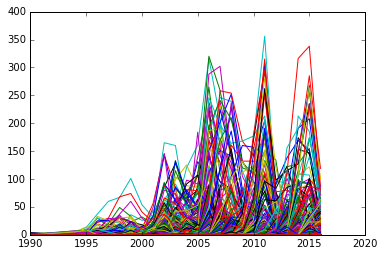

In [83]:
# Coole spaghetti over wie wanneer op de foto staat
q ="""
SELECT tag, date
FROM `mediafiles_mediatags_new` tagging
JOIN mediacollections 
ON tagging.collection_id = mediacollections.id
"""
import collections, itertools
per_year = collections.defaultdict(collections.Counter)
years = set()
for row in db.query(q):
    tag, added_at = row.values()
    per_year[tag][added_at[:4]] += 1
    years.add(added_at[:4])
    
plt.ticklabel_format(useOffset=False)
years = sorted(list(years))
for tag in per_year:
    plt.plot(years, [per_year[tag][y] for y in years])

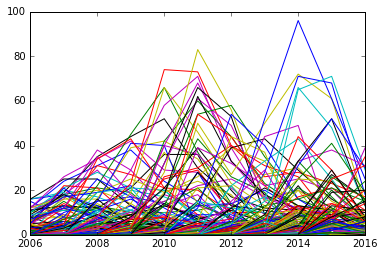

In [174]:
# Coole spaghetti over wie wanneer naar een activiteit gaat
q ="""
SELECT person_id AS person, startdate AS date
FROM `agenda_participants` went
LEFT OUTER JOIN agenda 
ON went.agenda_id = agenda.agenda_id
"""
import collections, itertools
per_year = collections.defaultdict(collections.Counter)
years = set()
for row in db.query(q):
    person, date = row.values()
    if person and date:
        per_year[person][date[:4]] += 1
        years.add(date[:4])
    
plt.ticklabel_format(useOffset=False)
years = sorted(list(years))[1:]
for tag in itertools.islice(per_year, None):
    plt.plot(years, [per_year[tag][y] for y in years])

In [50]:
photos ="SELECT DISTINCT collection_id, file_id FROM `mediafiles_mediatags`"
collections ="SELECT DISTINCT collection_id FROM `mediafiles_mediatags.train`"
tags ="SELECT DISTINCT tag FROM `mediafiles_mediatags.train`"
person_tags = '''
SELECT DISTINCT tag FROM mediatags
JOIN person ON person.postalname = mediatags.name
'''
n_photos = sum(1 for _ in db.query(photos))
n_tags = sum(1 for _ in db.query(tags))
print('Alle fotos * tags:', n_photos, '*', n_tags, '=', n_photos * n_tags)
n_person_tags = sum(1 for _ in db.query(person_tags))
print('Fotos * personen:', n_photos, '*', n_person_tags, '=', n_photos * n_person_tags)
n_collections = sum(1 for _ in db.query(collections))
print('Collecties * tags:', n_collections, '*', n_tags, '=', n_collections * n_tags)
print('Collecties * personen:', n_collections, '*', n_person_tags, '=', n_collections * n_person_tags)

('Alle fotos * tags:', 19258, '*', 2286, '=', 44023788)
('Fotos * personen:', 19258, '*', 768, '=', 14790144)
('Collecties * tags:', 888, '*', 2286, '=', 2029968)
('Collecties * personen:', 888, '*', 768, '=', 681984)


Dus voor foto's: 14M datapunten. Dat is te veel voor sqlite.

**We kunnen beter dingen doen per collectie!**